In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import math
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from torch.autograd import Variable

In [3]:
from spacetime import SpaceTime
from spacetime.models import MLPEncoder, MLPDecoder
from spacetime.metrics import count_accuracy

In [4]:
class arguments:
    def __init__(self):
        # data parameters 
        # configurations
        self.node_dict = {0:[0,1], 1:[2], 2:[3,4]}
        self.data_variable_size=sum(map(len, self.node_dict.values()))
        self.data_sample_size=10000
        self.noise_scale = 1.0
        self.graph_type='erdos-renyi'
        self.graph_degree=3
        self.graph_sem_type='linear-gauss'
        self.graph_linear_type='nonlinear_2'
        self.edge_types=2
        self.x_dims=1 #changed here
        self.z_dims=1

        # training hyperparameters
        self.optimizer='Adam'
        self.graph_threshold=0.3  # 0.3 is good 0.2 is error prune
        self.tau_A=1e-10
        self.lambda_A=0.
        self.c_A=1
        self.ordered_graph=True
        self.use_A_connect_loss=False
        self.use_A_positiver_loss=False

        self.seed=42
        self.epochs= 5
        self.batch_size=200 # note: should be divisible by sample size otherwise throw an error
        self.lr=3e-3  # basline rate = 1e-3
        self.encoder_hidden=64
        self.decoder_hidden=64
        self.temp=0.5
        self.k_max_iter=1e2

        self.save_folder='logs'

        self.h_tol=1e-8
        self.prediction_steps=10 
        self.lr_decay=200
        self.gamma= 1.0
        self.skip_first=False
        self.var=5e-5
        self.hard=False
        self.prior=False
        self.dynamic_graph=False
        
args = arguments()

In [5]:
# compute constraint h(A) value
def _h_A(A, m):
    x = torch.eye(m).double()+ torch.div(A*A, m)
    expm_A = torch.matrix_power(x, m)
    return torch.trace(expm_A) - m

def _h_A_ordered(A, node_dict):
    h_A = 0
    block_row, block_col = 0, 0

    for t, time_slice in node_dict.items():
        block_width = len(time_slice)
        block = A[block_row:, block_col:block_col+block_width]
        h_A += torch.sum(block*block)
        
        block_row += block_width
        block_col += block_width
    return h_A

def stau(w, tau):
    w1 = torch.nn.Threshold(0.,0.)(torch.abs(w)-tau)
    return torch.sign(w)*w1

# matrix loss: makes sure at least A connected to another parents for child
def A_connect_loss(A, tol, z):
    d = A.size()[0]
    loss = 0
    for i in range(d):
        loss +=  2 * tol - torch.sum(torch.abs(A[:,i])) - torch.sum(torch.abs(A[i,:])) + z * z
    return loss

# element loss: make sure each A_ij > 0
def A_positive_loss(A, z_positive):
    result = - A + z_positive * z_positive
    loss =  torch.sum(result)

    return loss

def kl_gaussian_sem(preds):
    mu = preds
    kl_div = mu * mu
    kl_sum = kl_div.sum()
    return (kl_sum / (preds.size(0)))*0.5

def nll_gaussian(preds, target, variance, add_const=False):
    mean1 = preds
    mean2 = target
    neg_log_p = variance + torch.div(torch.pow(mean1 - mean2, 2), 2.*np.exp(2. * variance))
    if add_const:
        const = 0.5 * torch.log(2 * torch.from_numpy(np.pi) * variance)
        neg_log_p += const
    return neg_log_p.sum() / (target.size(0))

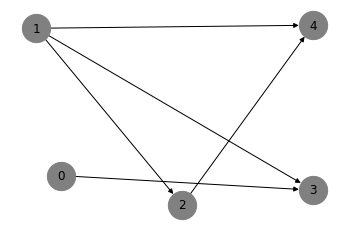

array([[[-1.18173662],
        [-0.30296397],
        [-0.09138962],
        [-2.32990215],
        [-4.44082998]],

       [[ 0.77269873],
        [ 1.20200259],
        [-5.47639109],
        [ 4.1181704 ],
        [ 7.55615984]]])

array([[ 0.   ,  0.   ,  0.   ,  0.797,  0.   ],
       [ 0.   ,  0.   , -1.396,  0.513,  1.08 ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -1.679],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [6]:
g = SpaceTime(args.node_dict)
g.generate_ordered(args.graph_degree, args.graph_type, seed=4)
g.generate_data(args.data_sample_size, args.x_dims, args.graph_sem_type, args.graph_linear_type, args.noise_scale)
g.time_order_nodes()
g.draw_graph()
g.data[:2]
g.ordered_adj()

In [7]:
#===================================
# training:
#===================================

def update_optimizer(optimizer, original_lr, c_A):
    '''related LR to c_A, whenever c_A gets big, reduce LR proportionally'''
    MAX_LR, MIN_LR = 1e-2, 1e-4

    estimated_lr = original_lr / (math.log10(c_A) + 1e-10)
    if estimated_lr > MAX_LR:
        lr = MAX_LR
    elif estimated_lr < MIN_LR:
        lr = MIN_LR
    else:
        lr = estimated_lr

    # set LR
    for parame_group in optimizer.param_groups:
        parame_group['lr'] = lr

    return optimizer, lr

def train(epoch, best_val_loss, ground_truth_G, lambda_A, c_A, optimizer):
    t = time.time()
    elbo_train = []
    nll_train = []
    shd_trian = []

    encoder.train()
    decoder.train()
    optimizer.step()
    scheduler.step()

    # update optimizer
    optimizer, lr = update_optimizer(optimizer, args.lr, c_A)

    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).double()
        optimizer.zero_grad()

        enc_x, logits, origin_A, z_gap, z_positive, myA, Wa = encoder(data)  # logits is of size: [num_sims, z_dims]
        edges = logits
        dec_x, output = decoder(data, edges, args.data_variable_size*args.x_dims, origin_A, Wa)

        if torch.sum(output != output):
            print('nan error\n')

        target = data
        preds = output
        variance = 0.

        # compute h(A)
        if args.ordered_graph:
            h_A = _h_A_ordered(origin_A, args.node_dict)
        else:
            h_A = _h_A(origin_A, args.data_variable_size)
        
    
        # reconstruction accuracy loss
        loss_elbo = nll_gaussian(preds, target, variance) + kl_gaussian_sem(logits)
        loss_nll = nll_gaussian(preds, target, variance)
        
        loss = loss_elbo
        loss += lambda_A*h_A + 0.5*c_A*h_A*h_A + 100.*torch.trace(origin_A*origin_A)
        loss += args.tau_A*torch.sum(torch.abs(origin_A))

        # other loss terms
        if args.use_A_connect_loss:
            connect_gap = A_connect_loss(origin_A, args.graph_threshold, z_gap)
            loss += lambda_A*connect_gap + 0.5*c_A*connect_gap*connect_gap

        if args.use_A_positiver_loss:
            positive_gap = A_positive_loss(origin_A, z_positive)
            loss += 0.1*(lambda_A*positive_gap + 0.5*c_A*positive_gap*positive_gap)
            
        loss.backward()
        loss = optimizer.step()

        myA.data = stau(myA.data, args.tau_A*lr)

        if torch.sum(origin_A != origin_A):
            print('nan error\n')

        # compute metrics
        graph = origin_A.data.clone().numpy()
        graph[np.abs(graph) < args.graph_threshold] = 0

        fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(graph))

        elbo_train.append(loss_elbo.item())
        nll_train.append(loss_nll.item())
        shd_trian.append(shd)

    if 'graph' not in vars():
        print('error on assign')

    return np.mean(elbo_train), np.mean(nll_train), graph, origin_A

In [8]:
from spacetime.simulate import torch_loader
ground_truth_G, numpy_data = g.graph, g.data
train_loader, valid_loader, test_loader = torch_loader(ground_truth_G, numpy_data, args.batch_size)

In [9]:
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

Optimization Finished!
Best Epoch: 0003	 Best ELBO: 0.1267088642 Best NLL: 0.0130526323
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0720807241 Best NLL: 0.0033318991
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0520672859 Best NLL: 0.0012811538
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0424515917 Best NLL: 0.0012811538
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0378135537 Best NLL: 0.0012694139
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0340069514 Best NLL: 0.0012444286
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0307698431 Best NLL: 0.0010319442
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0277214391 Best NLL: 0.0009152267
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0253058034 Best NLL: 0.0007569725
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0228938088 Best NLL: 0.0006176605
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0207462711 Best NLL: 0.0004502985
Optimization Finished!
Best Epoc

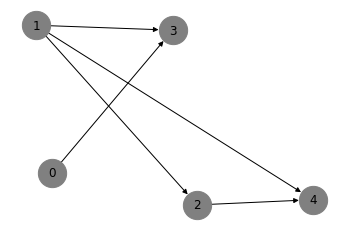

Ground truth graph
[[ 0.     0.     0.     0.797  0.   ]
 [ 0.     0.    -1.396  0.513  1.08 ]
 [ 0.     0.     0.     0.    -1.679]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]


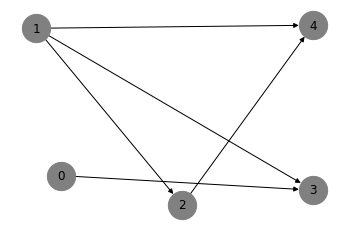

In [10]:
shd_trials = list()

for trial in range(1):
    t_total = time.time()

    best_ELBO_loss = np.inf
    best_epoch = 0
    best_ELBO_graph = None
    
    best_NLL_loss = np.inf
    best_NLL_graph = None

    # optimizer step on hyparameters
    c_A = args.c_A
    lambda_A = args.lambda_A
    h_A_new = torch.tensor(1.)
    h_tol = args.h_tol
    k_max_iter = int(args.k_max_iter)
    h_A_old = np.inf

    #===================================
    # load modules
    #===================================
    # add adjacency matrix A
    num_nodes = args.data_variable_size
    adj_A = np.zeros((num_nodes, num_nodes))

    encoder = MLPEncoder(args.data_variable_size*args.x_dims, args.x_dims, 
                         args.encoder_hidden, int(args.z_dims), adj_A).double()

    decoder = MLPDecoder(args.data_variable_size*args.x_dims, args.z_dims, 
                         args.x_dims, n_hid=args.decoder_hidden).double()

    #===================================
    # set up training parameters
    #===================================
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=args.lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay, gamma=args.gamma)
    
    #===================================
    # train model
    #===================================
    
    for step_k in range(k_max_iter):
        while c_A < 1e+20:
            for epoch in range(args.epochs):
                ELBO_loss, NLL_loss, graph, origin_A = train(epoch, best_ELBO_loss, ground_truth_G, lambda_A, c_A, optimizer)
                if ELBO_loss < best_ELBO_loss:
                    best_ELBO_loss = ELBO_loss
                    best_epoch = epoch
                    best_ELBO_graph = graph
                    
                if NLL_loss < best_NLL_loss:
                    best_NLL_loss = NLL_loss
                    best_epoch = epoch
                    best_NLL_graph = graph

            print("Optimization Finished!")
            print("Best Epoch: {:04d}\t".format(best_epoch),
                  "Best ELBO: {:.10f}".format(best_ELBO_loss),
                  "Best NLL: {:.10f}".format(best_NLL_loss))
            if ELBO_loss > 2 * best_ELBO_loss:
                break

            # update parameters
            A_new = origin_A.data.clone()
            
            if args.ordered_graph:
                h_A_new = _h_A_ordered(A_new, args.node_dict)
            else:
                h_A_new = _h_A(A_new, args.data_variable_size)

            if h_A_new.item() > 0.25 * h_A_old:
                c_A*=10
            else:
                break

            # update parameters
            # h_A, adj_A are computed in loss anyway, so no need to store

        h_A_old = h_A_new.item()
        lambda_A += c_A * h_A_new.item()

        if h_A_new.item() <= h_tol:
            break
    
    # test()
    fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(best_ELBO_graph))
    shd_trials.append(shd)
    
    print('Best ELBO Graph Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)
    print(np.around(best_ELBO_graph, 3))
    g2 = SpaceTime()
    g2.graph = nx.DiGraph(best_ELBO_graph)
    g2.infer_order()
    g2.time_order_nodes()
    g2.draw_graph()

    print('Ground truth graph')
    print(np.around(nx.to_numpy_array(ground_truth_G), 3))
    g.draw_graph()

In [11]:
encoder.eval()
decoder.eval()

MLPEncoder(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

MLPDecoder(
  (out_fc1): Linear(in_features=1, out_features=64, bias=True)
  (out_fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
mutilated = nx.to_numpy_array(ground_truth_G).copy()
mutilated[1, 2] = 0

mutilated_s2 = best_ELBO_graph.copy()
mutilated_s2[1, 2] = 0

In [13]:
graph_A = nn.Parameter(Variable(torch.from_numpy(best_ELBO_graph).double(), requires_grad=True))

origin_M = nn.Parameter(Variable(torch.from_numpy(mutilated).double(), requires_grad=True))

graph_M = nn.Parameter(Variable(torch.from_numpy(mutilated_s2).double(), requires_grad=True))

In [14]:
o_data = torch.FloatTensor(numpy_data).double()
enc_x, logits, origin_A, z_gap, z_positive, myA, Wa = encoder(o_data)
_, g_data = decoder(o_data, logits, args.data_variable_size*args.x_dims, origin_A, Wa)
_, g2_data = decoder(o_data, logits, args.data_variable_size*args.x_dims, graph_A, Wa)

nll_gaussian(g_data, torch.FloatTensor(numpy_data).double(), 0.0)
nll_gaussian(g2_data, torch.FloatTensor(numpy_data).double(), 0.0)

tensor(9.9796e-05, dtype=torch.float64, grad_fn=<DivBackward0>)

tensor(0.0106, dtype=torch.float64, grad_fn=<DivBackward0>)

In [15]:
_, g_data_M = decoder(o_data, logits, args.data_variable_size*args.x_dims, origin_M, Wa)

0 	 0.0013006 +- 0.043
1 	 0.0012728 +- 0.043
2 	 0.0014868 +- 0.066
3 	 0.0013054 +- 0.055
4 	 -0.0028174 +- 0.105


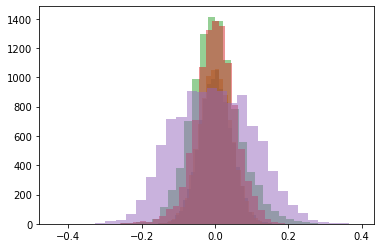

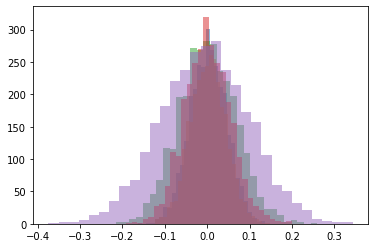

In [16]:
z_list = list()

for i in range(5):
    mean = np.around(np.mean(logits.detach().numpy()[:,i,:]), 7)
    std = np.around(np.std(logits.detach().numpy()[:,i,:]), 3)
    z_list.append(np.random.normal(mean, std, 3000))
    print('%s \t %s +- %s'%(i, mean, std))

for i in range(5):
    plt.hist(logits.detach().numpy()[:,i,:], alpha=0.5, bins=30)
plt.show()

for i in range(5):
    plt.hist(z_list[i], alpha=0.5, bins=30)

    
z_data = torch.FloatTensor(np.array(z_list).T.reshape(len(z_list[0]), len(z_list), 1))
pass;

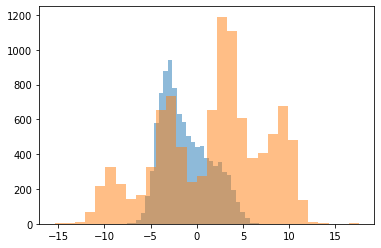

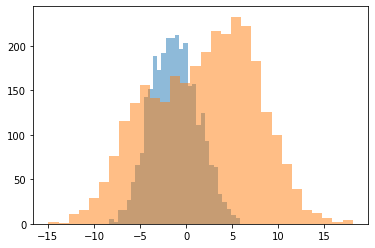

In [17]:
_, s_data = decoder(numpy_data, z_data, 
                    args.data_variable_size*args.x_dims, origin_A, Wa)
_, s2_data = decoder(numpy_data, z_data, 
                    args.data_variable_size*args.x_dims, graph_A, Wa)

plt.hist(numpy_data[:,2,:], alpha=0.5, bins=30)
plt.hist(numpy_data[:,4,:], alpha=0.5, bins=30)
plt.show()

# plt.hist(s_data.detach().numpy()[:,2,:], alpha=0.5, bins=30)
# plt.hist(s_data.detach().numpy()[:,4,:], alpha=0.5, bins=30)
# plt.show()

plt.hist(s2_data.detach().numpy()[:,2,:], alpha=0.5, bins=30)
plt.hist(s2_data.detach().numpy()[:,4,:], alpha=0.5, bins=30)
pass;

In [18]:
_, s2_data_M = decoder(o_data, z_data, args.data_variable_size*args.x_dims, graph_M, Wa)

In [19]:
class sampler:
    def __init__(self, data, bin_width = 1.0, discrete = False):
        self.discrete = discrete
        
        self.n = data.shape[0]
        self.n_vars = data.shape[1]
        
        self.data = np.squeeze(data)
        
        self.bin_width = bin_width
        self.joints = dict()
        self.axes = dict()
        
        for ivar in range(self.n_vars):
            self.compute_joint(ivar)
        
    def get_joint(self, *args):
        if args in self.joints:
            return self.joints[args]['joint'], self.joints[args]['axes']
        else:
            raise ValueError('Allowed Arguments: %s'%list(self.joints.keys()))
        
    def compute_joint(self, *args):
        bins = [self.get_bin_boundaries(i) for i in args]
        obs = self.data[:, list(args)]
        joint, bnds = np.histogramdd(obs, bins=bins, density=True)
        axes = [self.get_bin_centers(bnd) for bnd in bnds]
        self.joints[args] = {'joint':joint, 'axes':axes}

    def compute_conditional(self, d_vars, c_vars):
        assert type(d_vars) == list and type(c_vars) == list
        joint_tag = tuple(d_vars + c_vars)
        
        if joint_tag not in self.joints:
            self.compute_joint(*joint_tag)
            
        num = self.joints[joint_tag]['joint']
        den = np.tile(self.joints[tuple(c_vars[-1:])]['joint'], 
                      tuple(list(num.shape)[:-1] + [1]*1))
        
        if len(c_vars) == 1:
            return np.nan_to_num(num/den)
        else:
            den *= np.tile(self.compute_conditional(c_vars[0:1], c_vars[1:]), 
                           tuple(list(num.shape)[:-len(c_vars)] + [1]*len(c_vars)))
            return np.nan_to_num(num/den)
            
    def get_bin_boundaries(self, ivar):
        pad_lower = 0 if not self.discrete else -0.5
        pad_upper = 0 if not self.discrete else 1.5

        boundaries = np.arange(np.floor(self.data[:, ivar].min())+pad_lower, 
                               np.ceil(self.data[:, ivar].max())+pad_upper, 
                               self.bin_width)
        return boundaries
    
    def get_bin_centers(self, boundaries):
        centers = np.array([0.5*(boundaries[i]+boundaries[i+1]) 
                            for i, x in enumerate(boundaries[:-1])])
        return centers
    
    def plot_line(self, var):
        joint, axes = self.get_joint(var)
        return plt.plot(axes[0], joint)
    
    def plot_contour(self, var_x, var_y):
        joint, axes = self.get_joint(var_x, var_y)
        mesh = np.meshgrid(*axes)
        return plt.contour(*mesh, joint.T)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [20]:
prob_M = sampler(g_data_M.detach().numpy(), bin_width = 1.0)

In [21]:
prob_M_s2 = sampler(s2_data_M.detach().numpy(), bin_width = 1.0)

In [22]:
# prob_s = sampler(s_data.detach().numpy(), bin_width = 1.0)

# prob_s.plot_line(4)
# prob_s.plot_line(3)
# prob_s.plot_line(2)
# prob_s.plot_line(1)
# prob_s.plot_line(0)
# plt.show()
# prob_s.compute_joint(4, 2)

# axes_4_2 = prob_s.get_joint(4, 2)[1]
# joint, _ = prob_s.get_joint(4, 2)
# plt.contour(*np.meshgrid(*axes_4_2), joint.T)
# pass;

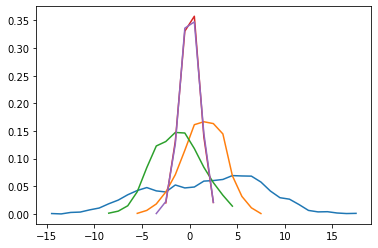

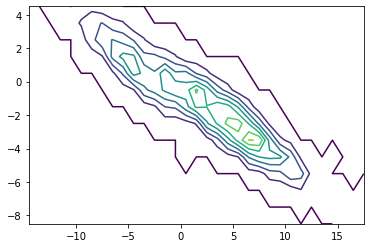

In [23]:
prob_s2 = sampler(s2_data.detach().numpy(), bin_width = 1.0)

prob_s2.plot_line(4)
prob_s2.plot_line(3)
prob_s2.plot_line(2)
prob_s2.plot_line(1)
prob_s2.plot_line(0)
plt.show()
prob_s2.compute_joint(4, 2)

axes2_4_2 = prob_s2.get_joint(4, 2)[1]
joint, _ = prob_s2.get_joint(4, 2)
plt.contour(*np.meshgrid(*axes2_4_2), joint.T)
pass;

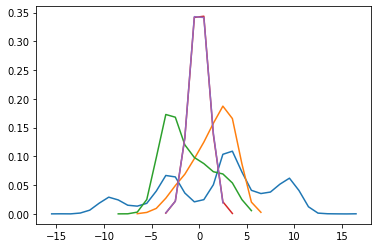

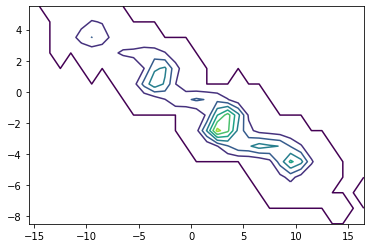

In [24]:
prob = sampler(numpy_data, bin_width = 1.0)
prob.plot_line(4)
prob.plot_line(3)
prob.plot_line(2)
prob.plot_line(1)
prob.plot_line(0)
plt.show()
prob.compute_joint(4, 2)
prob.plot_contour(4, 2)
pass;

In [25]:
do_two = np.zeros(prob.compute_conditional([4],[1,2])[:,0,:].shape)

for i in range(len(prob.joints[(1,)]['joint'])):
    do_two += prob.compute_conditional([4],[1,2])[:,i,:]*prob.joints[(1,)]['joint'][i]
    
do_two_s2 = np.zeros(prob_s2.compute_conditional([4],[1,2])[:,0,:].shape)

for i in range(len(prob_s2.joints[(1,)]['joint'])):
    do_two_s2 += prob_s2.compute_conditional([4],[1,2])[:,i,:]*prob_s2.joints[(1,)]['joint'][i]

/home/q1park/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Sharing Y axis')

(-6.5, 5.0)

(-10.5, 11.0)

(-10.5, 11.0)

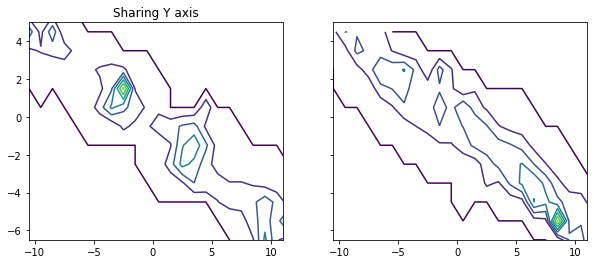

In [26]:
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob.get_joint(4, 2)[1]), do_two.T)
axs[0].set_title('Sharing Y axis')
axs[0].set_ylim(-6.5, 5)
axs[0].set_xlim(-10.5, 11)
axs[1].contour(*np.meshgrid(*prob_s2.get_joint(4, 2)[1]), do_two_s2.T)
axs[1].set_xlim(-10.5, 11)

Text(0.5, 1.0, 'Sharing Y axis')

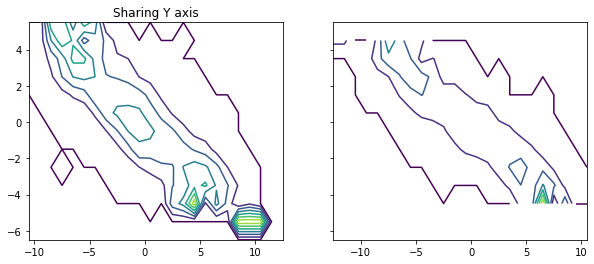

In [27]:
prob_M.compute_joint(4, 2)
prob_M_s2.compute_joint(4, 2)
    
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob_M.get_joint(4, 2)[1]), prob_M.compute_conditional([4],[2]).T)
axs[0].set_title('Sharing Y axis')
axs[1].contour(*np.meshgrid(*prob_M_s2.get_joint(4, 2)[1]), prob_M_s2.compute_conditional([4],[2]).T)

Text(0.5, 1.0, 'Sharing Y axis')

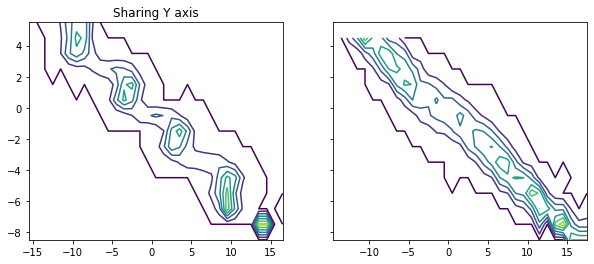

In [28]:
# Creates two subplots and unpacks the output array immediately
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob.get_joint(4, 2)[1]), prob.compute_conditional([4],[2]).T)
axs[0].set_title('Sharing Y axis')
axs[1].contour(*np.meshgrid(*prob_s2.get_joint(4, 2)[1]), prob_s2.compute_conditional([4],[2]).T)

Text(0.5, 1.0, 'Sharing Y axis')

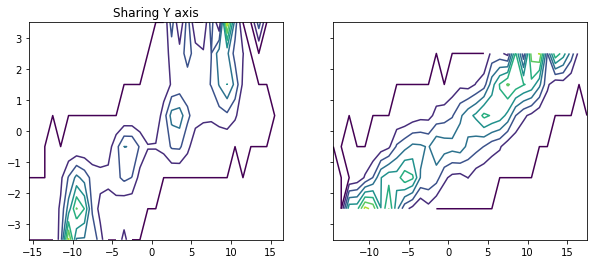

In [29]:
prob.compute_joint(4, 1)
prob_s2.compute_joint(4, 1)

# Creates two subplots and unpacks the output array immediately
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob.get_joint(4, 1)[1]), prob.compute_conditional([4],[1]).T)
axs[0].set_title('Sharing Y axis')
axs[1].contour(*np.meshgrid(*prob_s2.get_joint(4, 1)[1]), prob_s2.compute_conditional([4],[1]).T)

Text(0.5, 1.0, 'Sharing Y axis')

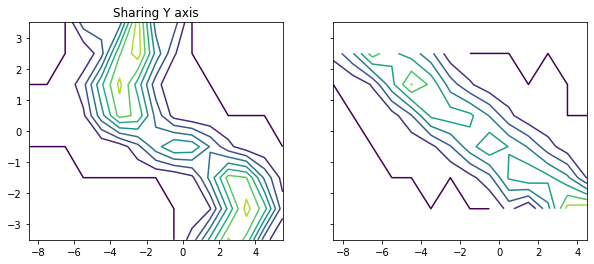

In [30]:
prob.compute_joint(2, 1)
prob_s2.compute_joint(2, 1)

# Creates two subplots and unpacks the output array immediately
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob.get_joint(2, 1)[1]), prob.compute_conditional([2],[1]).T)
axs[0].set_title('Sharing Y axis')
axs[1].contour(*np.meshgrid(*prob_s2.get_joint(2, 1)[1]), prob_s2.compute_conditional([2],[1]).T)

Text(0.5, 1.0, 'Sharing Y axis')

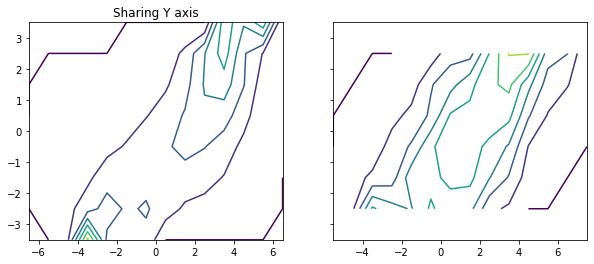

In [31]:
prob.compute_joint(3, 1)
prob_s2.compute_joint(3, 1)

# Creates two subplots and unpacks the output array immediately
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob.get_joint(3, 1)[1]), prob.compute_conditional([3],[1]).T)
axs[0].set_title('Sharing Y axis')
axs[1].contour(*np.meshgrid(*prob_s2.get_joint(3, 1)[1]), prob_s2.compute_conditional([3],[1]).T)

Text(0.5, 1.0, 'Sharing Y axis')

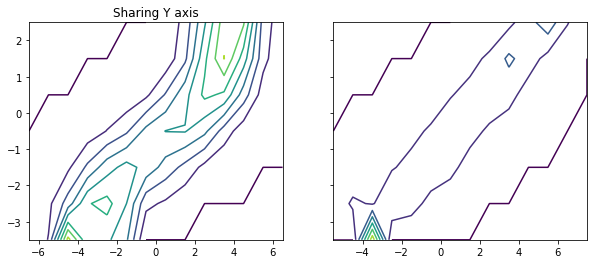

In [32]:
prob.compute_joint(3, 0)
prob_s2.compute_joint(3, 0)

# Creates two subplots and unpacks the output array immediately
f, axs = plt.subplots(1, 2, sharey=True, figsize = (10,4))
axs[0].contour(*np.meshgrid(*prob.get_joint(3, 0)[1]), prob.compute_conditional([3],[0]).T)
axs[0].set_title('Sharing Y axis')
axs[1].contour(*np.meshgrid(*prob_s2.get_joint(3, 0)[1]), prob_s2.compute_conditional([3],[0]).T)

In [33]:
stone_data = np.array([[[0.], [0.], [1.]]]*84 + 
                      [[[0.], [0.], [0.]]]*(87-84) + 
                      [[[0.], [1.], [1.]]]*234 + 
                      [[[0.], [1.], [0.]]]*(270-234) + 
                      [[[1.], [0.], [1.]]]*192 + 
                      [[[1.], [0.], [0.]]]*(263-192) + 
                      [[[1.], [1.], [1.]]]*55 + 
                      [[[1.], [1.], [0.]]]*(80-55))

In [34]:
prob2 = sampler(stone_data, bin_width = 1., discrete = True)
prob2.compute_conditional([2],[0])[1,:]
prob2.compute_conditional([2],[1])[1,:]
prob2.joints

array([0.8907563 , 0.72011662])

array([0.78857143, 0.82571429])

{(0,): {'joint': array([0.51, 0.49]), 'axes': [array([0., 1.])]},
 (1,): {'joint': array([0.5, 0.5]), 'axes': [array([0., 1.])]},
 (2,): {'joint': array([0.19285714, 0.80714286]), 'axes': [array([0., 1.])]},
 (2,
  0): {'joint': array([[0.05571429, 0.13714286],
         [0.45428571, 0.35285714]]), 'axes': [array([0., 1.]),
   array([0., 1.])]},
 (2,
  1): {'joint': array([[0.10571429, 0.08714286],
         [0.39428571, 0.41285714]]), 'axes': [array([0., 1.]),
   array([0., 1.])]}}

In [35]:
prob2.compute_conditional([2],[0,1])[:,0,0]*prob2.joints[(0,)]['joint'][0] + \
prob2.compute_conditional([2],[0,1])[:,1,0]*prob2.joints[(0,)]['joint'][1]

prob2.compute_conditional([2],[0,1])[:,0,1]*prob2.joints[(0,)]['joint'][0] + \
prob2.compute_conditional([2],[0,1])[:,1,1]*prob2.joints[(0,)]['joint'][1]

prob2.compute_conditional([2],[0,1])[:,0,:]*prob2.joints[(0,)]['joint'][0] + \
prob2.compute_conditional([2],[0,1])[:,1,:]*prob2.joints[(0,)]['joint'][1]

array([0.14986758, 0.85013242])

array([0.221125, 0.778875])

array([[0.14986758, 0.221125  ],
       [0.85013242, 0.778875  ]])

In [36]:
# shd_trials
# np.mean(shd_trials)
# np.std(shd_trials)

####### node_dict = {0:[0,1], 1:[2,3,4], 2:[5,6]}
#### noise = 0.05
### h_A experiments
# [9, 9, 11, 9, 9, 10, 9, 6, 9, 7]
# 8.8 +- 1.32664991614216
### h_A_ordered experiments
# [2, 6, 7, 5, 5, 4, 6, 7, 6, 6]
# 5.4 +- 1.42828568570857

#### noise = 0.1
### h_A experiments
# [7, 8, 7, 9, 8, 8, 4, 9, 5, 8]
# 7.3 +- 1.5524174696260025
### h_A_ordered experiments
# [1, 1, 5, 4, 4, 4, 4, 5, 3, 1]
# 3.2 +- 1.5362291495737217